**Load the required data and libraries**

In [1]:
# Libraries  
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings 

warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

In [2]:
# Data 
df = pd.read_csv("../data/PLP Patient Lifetime Profile.csv", 
                             encoding='UTF-16', delimiter="\t")

appointment_df = pd.read_csv("../data/Appointments List.csv", 
                             encoding='UTF-16', delimiter="\t")

# INTRODUCTION

In recent times, a detailed regression analysis on appointment trends revealed a significant drop in the rate of MH infusion appointments starting from mid-2023, with the decline becoming more pronounced by early 2024. This observation raised concerns about the potential causes of this trend, particularly whether pricing changes might have contributed to patients discontinuing their services.

The primary goal of this project was to investigate the relationship between payments and patient retention to determine if changes in cost played a role in patient churn. By analyzing patient payment data and appointment records, we aimed to identify patterns that could explain the steep decline in MH infusion rates and provide actionable insights.

**Objectives**

This project sought to address the following specific questions:

- Did the cost of services directly contribute to patient churn?
- What was the rate of patient retention over time, and how did it vary across different patient groups?
- Was the increase in service costs the primary driver of patient churn?

The findings from this analysis will help uncover the underlying factors influencing patient behavior and provide recommendations for addressing any pricing-related issues that may be affecting retention. Additionally, the insights will guide further exploration into broader economic and operational factors impacting service delivery and patient satisfaction.

# EXPLANATORY DATA ANALYSIS 
## Data Assessment 

In [3]:
df.head()

,Patient FID,ChartNumber,ZipCode (tmtPLPPatientLifeTimeProfile),CreatedDate,First Date Of Service,Last Date Of Service,Last Primary Appt Type Group,Last Facility City,Days Since Last DoS dim,Next Scheduled Appt Date,...,Total Insurance Payments,Total Patient Payments,Total Writeoff Amount,Charge Code Count,Diagnosis Code Count,Vists / Months Span,OutstandingAR,Count of tmtPLPPatientLifeTimeProfile,SeenProvidersCount,PatientsWithVisit%
0,Grand Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,...,"$1,240,855.95","$14,861,653.28","$995,613.48","8,024","3,473","6,599.64","$1,388,296.81","1,602",0,99.94%
1,5283,1,02139,01/22/18,01/22/18,05/29/18,TMS,CAMBRIDGE,2366,NaN,...,"$6,147.36","$3,464.68","$6,187.96",4,1,12.75,"$6,147.36",1,0,100.00%
2,5286,2,02118,01/23/18,01/16/18,06/27/18,MH Infusion,CAMBRIDGE,2337,NaN,...,NaN,"$4,450.00",NaN,2,1,2.60,$0.00,1,0,100.00%
3,5287,3,02474,01/23/18,01/29/18,02/13/18,MH Infusion,CAMBRIDGE,2471,NaN,...,NaN,"$3,400.00",NaN,2,1,7.00,$0.00,1,0,100.00%
4,5347,5,02127,01/23/18,01/25/18,03/27/18,MH Infusion,CAMBRIDGE,2429,NaN,...,NaN,"$3,900.00",NaN,2,1,4.50,$0.00,1,0,100.00%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603 entries, 0 to 1602
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Patient FID                             1603 non-null   object
 1   ChartNumber                             1603 non-null   object
 2   ZipCode (tmtPLPPatientLifeTimeProfile)  1603 non-null   object
 3   CreatedDate                             1603 non-null   object
 4   First Date Of Service                   1603 non-null   object
 5   Last Date Of Service                    1603 non-null   object
 6   Last Primary Appt Type Group            1501 non-null   object
 7   Last Facility City                      1469 non-null   object
 8   Days Since Last DoS dim                 1603 non-null   object
 9   Next Scheduled Appt Date                144 non-null    object
 10  Financial Class                         1603 non-null   object
 11  Seen

## Data Preparation

Before diving into the analysis, the data underwent some careful cleaning and organization to ensure accuracy. Here’s what was done:

1. **Removed an irrelevant record:** The very first record was inaccurate and unnecessary, so it was excluded from the analysis.
2. **Standardized appointment statuses:** To keep things consistent, all "Made" appointments were categorized as "Seen," focusing only on successful appointments for analysis.
3. **Cleaned up patient IDs:** Any extra spaces in chart numbers were removed, and all IDs were converted to a consistent format for easy comparison between the appointments and patient lifetime datasets.
4. **Formatted dates:** Dates across the datasets were standardized into a recognizable format for smoother processing.

With these steps, the data was ready for the next stage—analyzing patient payments over time. Additional adjustments may be made as needed during the analysis process.

In [5]:
# drop the first row 
df.drop(index=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# Clean the appointment data set 
## Replace "Made" to "Seen"
appointment_df["Appt Status Description"].replace("Made", "Seen", inplace=True)
## Delete the first  and second rows 
appointment_df.drop(index=[0, 1], inplace=True)
appointment_df.reset_index(inplace=True, drop=True)

# Convert chart numbers to integers to deal with white spaces  
## PLP data 
plp_chartnumbers = [int(chart_number) for chart_number in df["ChartNumber"]]
df["ChartNumber"] = plp_chartnumbers

##  Appointment data 
appt_chartnumbers = [int(chart_number) for chart_number in appointment_df["Chartnumber"]]
appointment_df["Chartnumber"] = appt_chartnumbers

# Convert the datetime like variables to datetime 
df["CreatedDate"] = pd.to_datetime(df["CreatedDate"], errors="coerce")
df["First Date Of Service"] = pd.to_datetime(df["First Date Of Service"], errors="coerce")
df["Last Date Of Service"] = pd.to_datetime(df["Last Date Of Service"], errors="coerce")


## Data Analysis and Visualization

**Ideas for Analysis**

To uncover meaningful insights, the data was segmented into the following patient groups:

- **Patients Before Mid-2023:** Those who concluded their services before mid-2023 (`patients_before_mid2023`).
- **Late 2023 Patients:** Those who began their services after mid-2023 but concluded before 2024 (`patients_late_2023`).
- **All-Time Patients:** Those whose services spanned from before mid-2023 and continued into 2024 (`all_time_patients`).
- **2024 Patients**: Those whose services occurred exclusively in 2024 (`patients_2024`). This group is especially crucial as the MH infusion drop was observed to steepen in 2024.

The analysis aims to explore the following areas:

- The role of insurance and its offerings to patients.
- The proportion of expenses covered by insurance versus the amount paid out-of-pocket by patients.
- The total cost incurred by patients for their services.
- Pay-per-visit trends, focusing specifically on successful appointments.

By breaking down the data in this way, the goal is to identify patterns and uncover any potential links between costs and patient behavior.

**Split the patients into four categories**

In [6]:
decided_date = pd.to_datetime("2023-07-01") # mid-2023
begin_2024 = pd.to_datetime("2024-01-01") # begining 2024

# Ones who had their last day in service before mid-2023 as patients_before_mid2023
patients_before_mid2023 = df[df["Last Date Of Service"]<decided_date].reset_index(drop=True)

# Ones who had their first day of service but before 2024
patients_late_2023 = df[(df["First Date Of Service"]>=decided_date)&
                           (df["Last Date Of Service"]<begin_2024)].reset_index(drop=True)

# Special
## Ones who had their first day of service from the beginning of 2024
patients_2024 = df[df["First Date Of Service"]>=begin_2024].reset_index(drop=True)

# Ones who had their services run throughout before through to 2024 as all_time_patients
all_time_patients = df[(df["First Date Of Service"]<decided_date)\
                      &(df["Last Date Of Service"]>=begin_2024)].reset_index(drop=True)

### Insurance Analysis 

In [7]:
# Count the null values (Ratio of null values)
df["Total Insurance Payments"].isna().sum()/len(df)

0.8071161048689138

Upon reviewing the insurance data, it was found that approximately 80% of the entries were missing. Due to this significant gap, a meaningful analysis of insurance contributions was not possible.

As a result, the focus has shifted to analyzing the amount paid directly by each patient, which provides a clearer and more complete picture of the financial aspect of the services.

### Payment Analysis

This phase will focus on uncovering meaningful insights into the amounts paid by patients, looking for trends, patterns, and any potential impact on customer retention.

The goal is to understand if payment structures or costs may have contributed to the changes observed in MH infusion rates. 

To ensure a clear approach, a few assumptions were made:

- All services were charged at the same rate(Including MH infusion).
- Canceled appointments were not invoiced, so they are excluded from the payment analysis.


In [8]:
# count the null values (ration of null values)
df["Total Patient Payments"].isna().sum()/len(df)

0.031835205992509365

After inspecting the completeness of the total payment variable, only 3% of the patient payment data is missing, allowing us to proceed with the analysis.

In [9]:
# Clean the data 
## Remove the "$" sign
## Deal with the null values 
## Convert the whole variable to numeric 

def clean_amount(amount):
    """
    Docstring 
    Here is how the total payments will be cleaned 
        - Remove the "$" sign
        - Deal with the null values 
        - Convert the whole variable to numeric 
    """
    
    if pd.isnull(amount):
        return None # Handle null values 
    
    # Remove "$" and commas
    amount = amount.replace("$", "").replace(",", "").strip()
    
    return float(amount)

# Test the function
clean_amount(df["Total Patient Payments"][0])

3464.68

In [10]:
# Apply the function to the "Total Patient Payments" column for each category

## ----- Run the below code once
patients_before_mid2023["Total Patient Payments"] = patients_before_mid2023["Total Patient Payments"].apply(clean_amount)
patients_late_2023["Total Patient Payments"] = patients_late_2023["Total Patient Payments"].apply(clean_amount)
all_time_patients["Total Patient Payments"] = all_time_patients["Total Patient Payments"].apply(clean_amount)
patients_2024["Total Patient Payments"] = patients_2024["Total Patient Payments"].apply(clean_amount)

**Distribution**

A distribution in data refers to how values are spread or arranged within a dataset. It provides insight into the frequency or likelihood of different outcomes or measurements occurring.

In this analysis, we plotted distribution plot(blend of histogram and density plot) to show the distribution of the total payment per patients in each category. 

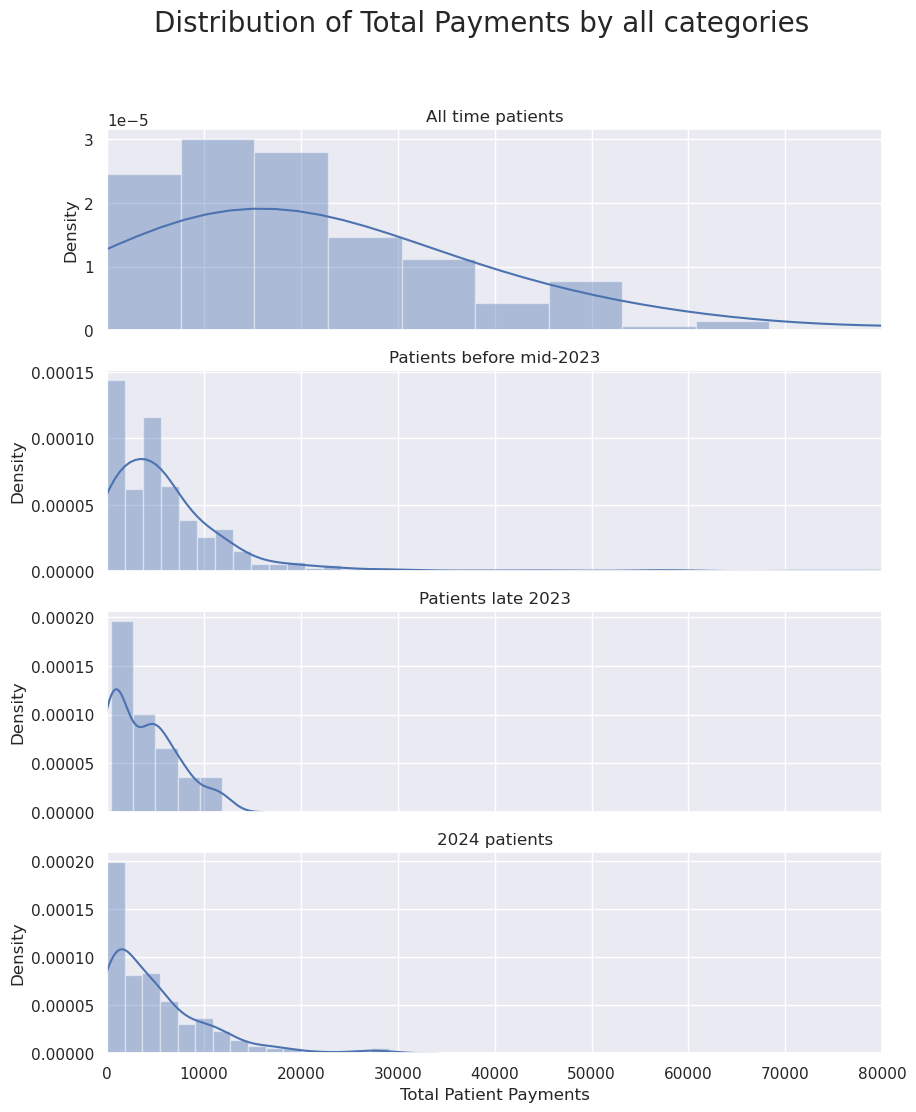

In [11]:
# Distribution of payments 

fig, axes = plt.subplots(nrows=4, ncols=1,
                        figsize=(10, 12), sharex=True)

# Total Patient Payments 
## All time patients 
sns.distplot(all_time_patients["Total Patient Payments"], ax = axes[0])
axes[0].set_title("All time patients")

## Before mid 2023
sns.distplot(patients_before_mid2023["Total Patient Payments"], ax = axes[1])
axes[1].set_title("Patients before mid-2023")

## After mid 2023
sns.distplot(patients_late_2023["Total Patient Payments"], ax = axes[2])
axes[2].set_title("Patients late 2023")

## 2024
sns.distplot(patients_2024["Total Patient Payments"], ax = axes[3])
axes[3].set_title("2024 patients")

plt.xlim(0, 80000)
plt.suptitle("Distribution of Total Payments by all categories", fontsize=20)
plt.show()

From the histograms above, we can draw the following conclusions:

* While all categories exhibit a similar shape of distribution, all-time patients (those who have been receiving services since before mid-2023 and continued through 2024) recorded the highest total payments for their services.
* The majority of all-time patients made total payments ranging between $10,000 and $20,000.
* Patients in all other categories predominantly paid below 5,000 dollars for their services.


The dataset spans data from as far back as 2018. As a result, it can be inferred that all-time patients and those in the `before mid-2023` category have had longer service periods (up to five years), while patients in the `late mid-2023` and `2024` categories have had much shorter periods of service—approximately six months to one year. This disparity in service duration could explain why `all-time patients` had significantly higher total payments compared to the more recent patient categories.

The following steps will be taken to further investigate the issue of payments and uncover differences between the categories:

* **Preprocess the data** to determine the actual number of visits for each patient.
* **Calculate the pay-per-appointment** for each patient to gain a clearer understanding of individual payment patterns.
* **Analyze the distribution** of pay-per-appointment values across all categories to identify any notable differences.

<span style="color: orange;">**Note:**</span> It is assumed that each successful appointment was billed at a uniform rate.

### Breakdown to pay per visit

Before calculating pay per visit, the following preprocessing steps were performed:

- Selected all successful appointments to ensure only valid data is included.
- Aggregated the total count of successful appointments for each patient.
- Calculated the pay per visit for each patient by dividing the total payment by the number of successful appointments.

This process ensures that the pay per visit is accurately calculated for each patient.

In [12]:
# Prepare the data 
## Get all the successfull appointments 
seen_app_df = appointment_df[appointment_df["Appt Status Description"]=="Seen"].reset_index(drop=True)

## Count the number of appointments per patient 
appointments_per_patient = seen_app_df[["Chartnumber", "Appt Type Group"]].groupby("Chartnumber").count()

appointments_per_patient.reset_index(inplace=True)
appointments_per_patient.rename({"Appt Type Group":"appointment count"}, axis=1, inplace=True)

# Merge with the other PLP data sets and calculate pay per appointment
## Merge with patients before mid-2023
patients_before_mid2023 = patients_before_mid2023.merge(appointments_per_patient,
                                                        left_on="ChartNumber",
                                                        right_on="Chartnumber")
## Calculate pay per visit 
patients_before_mid2023["pay_per_visit"] = patients_before_mid2023["Total Patient Payments"]/\
patients_before_mid2023["appointment count"]

## Merge with patients late 2023
patients_late_2023 = patients_late_2023.merge(appointments_per_patient,
                                                      left_on="ChartNumber",
                                                      right_on="Chartnumber")

## Calculate pay per visit 
patients_late_2023["pay_per_visit"] = patients_late_2023["Total Patient Payments"]/\
patients_late_2023["appointment count"]

## Merge with all time patients 
all_time_patients = all_time_patients.merge(appointments_per_patient,
                                            left_on="ChartNumber",
                                            right_on="Chartnumber")

## Calculate pay per visit 
all_time_patients["pay_per_visit"] = all_time_patients["Total Patient Payments"]/\
all_time_patients["appointment count"]


## Merge with 2024 patients
patients_2024 = patients_2024.merge(appointments_per_patient,
                                    left_on="ChartNumber",
                                    right_on="Chartnumber")

## Calculate pay per visit 
patients_2024["pay_per_visit"] = patients_2024["Total Patient Payments"]/\
patients_2024["appointment count"]

## Remove all records with zero appointments 
patients_before_mid2023 = patients_before_mid2023[patients_before_mid2023["appointment count"]!=0]
patients_late_2023 = patients_late_2023[patients_late_2023["appointment count"]!=0]
all_time_patients = all_time_patients[all_time_patients["appointment count"]!=0]
patients_2024 = patients_2024[patients_2024["appointment count"]!=0]

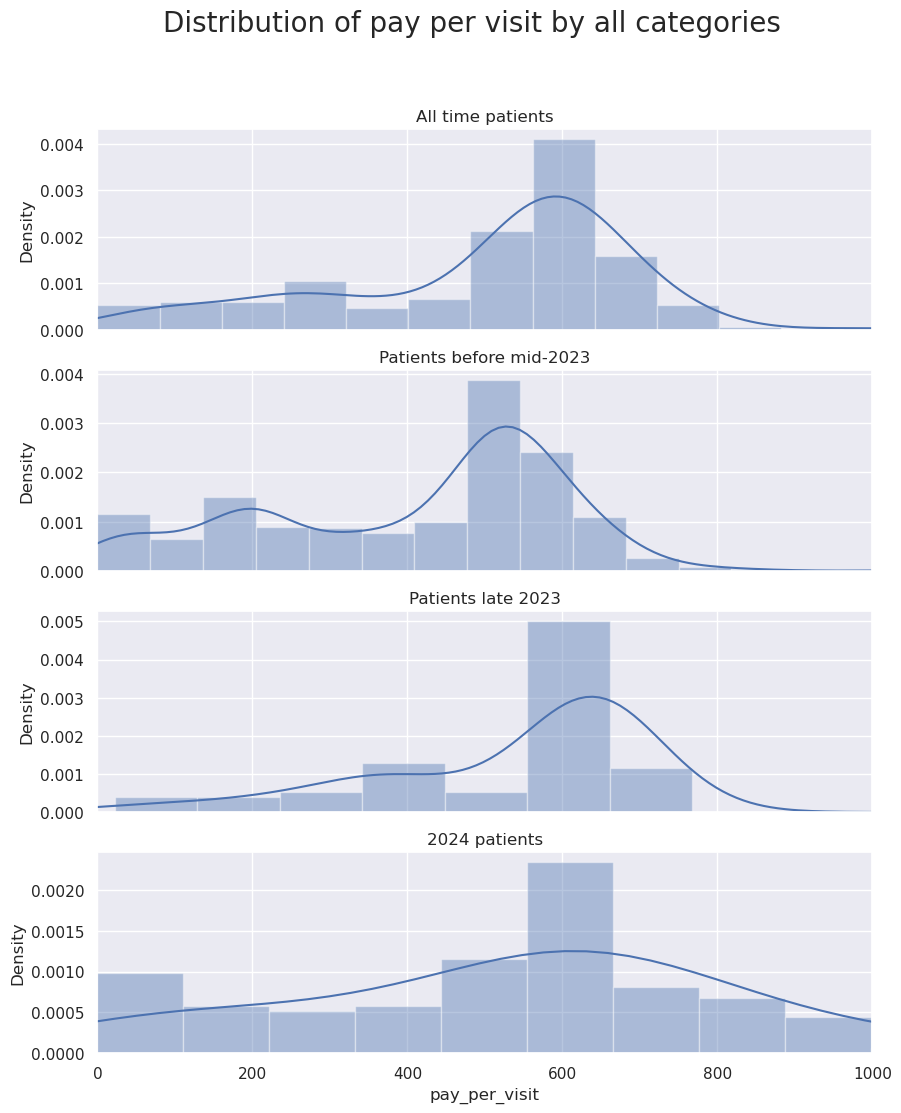

In [13]:
# Calculate the distribution of pay per visit

fig, axes = plt.subplots(nrows=4, ncols=1,
                        figsize=(10, 12), sharex=True)

# Total Patient Payments 
## All time patients 
sns.distplot(all_time_patients["pay_per_visit"], ax = axes[0])
axes[0].set_title("All time patients")

## Before mid 2023
sns.distplot(patients_before_mid2023["pay_per_visit"], ax = axes[1])
axes[1].set_title("Patients before mid-2023")

## After mid 2023
sns.distplot(patients_late_2023["pay_per_visit"], ax = axes[2])
axes[2].set_title("Patients late 2023")

## 2024 patients 
sns.distplot(patients_2024["pay_per_visit"], ax = axes[3])
axes[3].set_title("2024 patients")

plt.xlim(0, 1000)
plt.suptitle("Distribution of pay per visit by all categories", fontsize=20)
plt.show()

The histograms above illustrate the distribution of pay per visit for all categories. All the categories follow a normal distribution, with a slight left skew. However, most patients before 2023 paid the least. The distribution shows that patients in the "late 2023" and "2024" categories generally paid more than $600 per visit.

### Summary Statistics for the payments 

To gain a clearer understanding of the payment trends across each category, let's calculate both the median and the mean (average) pay per visit for each group

In [14]:
# Compute the summary statistics
d1 = pd.DataFrame(all_time_patients["pay_per_visit"].describe())
d2 = pd.DataFrame(patients_before_mid2023["pay_per_visit"].describe())
d3 = pd.DataFrame(patients_late_2023["pay_per_visit"].describe())
d4 = pd.DataFrame(patients_2024["pay_per_visit"].describe())

# Concatenate the data frames and merge the rows 
d5 = pd.concat([d1, d2, d3, d4], 
               axis=1)
d5.columns = ["all_time", "before mid-2023", "late 2023", "2024"]


# Drop the max and min indices  and the quartiles 
d5.drop(index=['min', '25%', '75%', 'max', 'std'], inplace=True)

# Rename the remaining indices 
d5.index = ['count', 'mean', 'median']

# Show the data set 
d5

,all_time,before mid-2023,late 2023,2024
count,188.000000,846.000000,73.000000,265.000000
mean,499.840100,410.131706,549.336474,624.260872
median,563.397129,487.500000,609.375000,606.250000


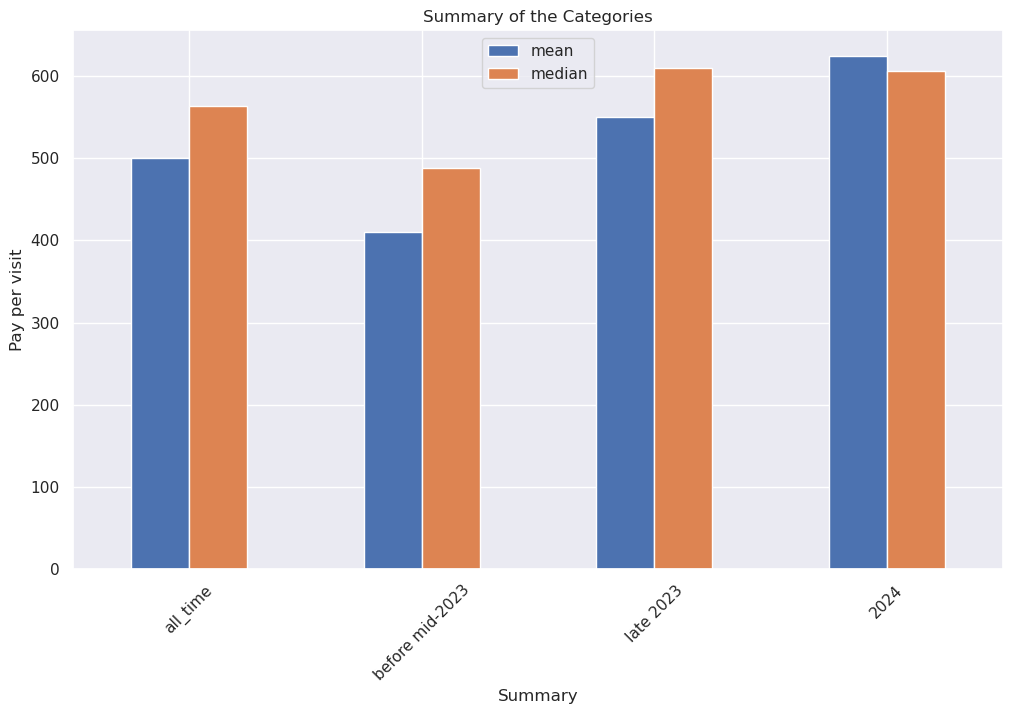

In [16]:
# Plot the data
d5.transpose().drop("count", axis=1).plot(kind="bar", figsize=(12, 7), rot=45)
plt.title("Summary of the Categories")
plt.xlabel("Summary")
plt.ylabel("Pay per visit")
plt.legend(loc="upper center")

# CONCLUSION 

This analysis offers a detailed look at the changes in payments charged to different categories of patients over time, revealing important trends and insights. After careful examination of the data, the following findings were made:

* Patients who visited before mid-2023 tended to pay the least per visit, with their payment amounts generally staying within a lower range.
* Patients in the late 2023 and 2024 categories paid significantly higher amounts per visit. This indicates a clear shift in pricing over time.
* A gradual increase in prices was observed starting from mid-2023, signaling potential changes in pricing policies or external factors that affected the cost of services.

Given these findings, here are a few key areas I recommend exploring further:

- Are there any hidden or additional charges that may have been introduced to patients, which might explain the increase in payments?
- Could inflation have played a role in driving up the cost of services for patients in the later periods?
- Were there any internal factors, such as the provision of services becoming more expensive, that contributed to the rise in payments?

I also suggest investigating why 188 patients(`all-time patients`) continued to undergo treatments despite the rising costs. There could be something unique about these patients or their situations that warrants further exploration.

While I have worked diligently to provide a comprehensive analysis, there were some challenges along the way. One key issue was the inability to obtain specific payment data for MH Infusion, which meant I had to assume it was priced similarly to other services in the analysis. This assumption could affect the accuracy of the findings, especially if the payment structure for MH Infusion differs.

Moving forward, I will continue to refine the analysis, particularly around the MH Infusion data, and will keep you updated on any new insights that emerge. I am confident that this analysis, with a bit more data, will provide even deeper insights into the trends shaping the patient payment experience.